In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from random import shuffle

import os
import glob
import cv2
import time
from helper_functions import *

%matplotlib inline  

from sklearn.svm import LinearSVC
from sklearn import svm, grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip


print('Running this from: ', os.getcwd())

Running this from:  /home/tebd/Documents/sdc/CarND-Vehicle-Detection


In [13]:
window_patches = [(64, 64), (96, 96), (128, 128)]
y_pos = [(400, 500), (400, 500), (400, 500)]
overlap = (0.8, 0.8)
threshold = 0.7
heat_t = 2

def getYUVHog(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    features_y = get_hog_features(img[:,:,0],orient=8, pix_per_cell=8, cell_per_block=2, 
                                    vis=False, feature_vec=True)
    
    features_u = get_hog_features(img[:,:,1],orient=8, pix_per_cell=8, cell_per_block=2, 
                                    vis=False, feature_vec=True)
    
    features_v = get_hog_features(img[:,:,2],orient=8, pix_per_cell=8, cell_per_block=2, 
                                    vis=False, feature_vec=True)
    
    return np.concatenate((features_y, features_u, features_v))

def slide_window(img):
    window_list = []
    
    for (xy_window, y_start_stop) in zip(window_patches, y_pos):
        x_start = int(img.shape[1]/2)
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        nx_pix_per_step = np.int(xy_window[0] * (1. - overlap[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - overlap[1]))
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
                
    return window_list

def get_fit_windows(img, windows, clf, scaler):
    
    on_windows = []
    
    for window in windows:
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        features = getYUVHog(window_img)
        features = scaler.transform(np.array(features).reshape(1, -1))
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    return on_windows

def add_heat(heatmap, bboxes):
    # Iterate through each bbox.
    for bbox in bboxes:
        # Add +1 for all pixels inside each bbox.
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap.
    return heatmap
    
def apply_threshold(heatmap):
    # Zero out pixels below the threshold.
    heatmap[heatmap <= heat_t] = 0
    # Return thresholded map.
    return heatmap

def draw_labeled_bboxes_vid(img, heatmap):
    labels = label(heatmap)
    bboxes = []
    for vehicle in range(1, labels[1]+1):
        nonzero = (labels[0] == vehicle).nonzero()
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    img = draw_boxes(img, bboxes)
    return img

In [14]:
src_X = []
src_y = []

#Separately extract features for train and test
vehicles_train = glob.glob('./data/vehicles/vehicles_train/*.png')
non_vehicles_train = glob.glob('./data/non-vehicles/non-vehicles_train/*.png')
vehicles_test = glob.glob('./data/vehicles/vehicles_test/*.png')
non_vehicles_test = glob.glob('./data/non-vehicles/non-vehicles_test/*.png')
veh_all = vehicles_train + vehicles_test
shuffle(veh_all)
nonVeh_all = non_vehicles_train+non_vehicles_test
shuffle(nonVeh_all)

for img_name in veh_all:
    img = cv2.imread(img_name)
    features = getYUVHog(img)
    src_X.append(features)
    src_y.append(True)

for img_name in nonVeh_all:
    img = cv2.imread(img_name)
    features = getYUVHog(img)
    src_X.append(features)
    src_y.append(False)


In [15]:
X_scaler = StandardScaler().fit(src_X)
input_images = X_scaler.transform(src_X)

X_train, X_test, y_train, y_test = train_test_split(src_X, src_y, test_size=0.2, stratify=src_y, random_state=1)

clf = LinearSVC(random_state=1)
clf.fit(X_train, y_train)

print('Test accuracy: %.1f%%' % (100. * clf.score(X_test, y_test)))

Test accuracy: 98.8%


In [16]:
pickle.dump( clf, open( "model_svm.p", "wb" ) )
pickle.dump(X_scaler,open('X_scaler.p','wb'))

In [25]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
fit_windows = get_fit_windows(img, windows, clf, X_scaler)
img_windows = draw_boxes(img, fit_windows)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, fit_windows)
heatmap = apply_threshold(heatmap)
img = draw_labeled_bboxes_vid(img, heatmap)

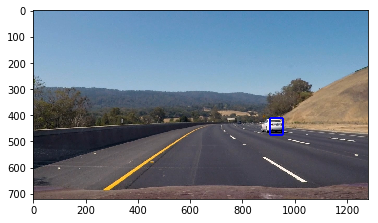

In [26]:
plt.imshow(img)


In [ ]:
frame_count = 5

class VehicleDetector:
    def __init__(self):
        self.bboxes = []
    
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-frame_count:]
    
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        return heatmap

In [ ]:
vehicle_detector = VehicleDetector()

def video_pipeline(img):
    
    #global vehicle_detector
    
    #if vehicle_detector is None:
        #vehicle_detector = VehicleDetector()
    windows = slide_window(img)
    fit_windows = get_fit_windows(img, windows, clf, X_scaler)
    vehicle_detector.add_bboxes(fit_windows)
    heatmap = vehicle_detector.heatmap()
    img = draw_labeled_bboxes_vid(img, heatmap)
    return img


In [ ]:
video_output = 'Submission_p5.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)


In [11]:
out = video_pipeline(img)

NameError: name 'video_pipeline' is not defined